# Merging of datasets and preliminary analysis

In [32]:
import os
import time
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import censusdata
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

os.chdir('/Users/theomoers/Documents/Columbia SIPA/Classes/Spring/Applying ML/ml-final-project/')
randomState = 18

# plt.switch_backend('pgf') # change to 'pgf' for LaTeX export # use inline for Jupyter Notebook
# %matplotlib inline 

plt.rcParams.update({ 
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
})

CB_color_cycle = [
    '#56B4E9', '#008000', '#CC79A7', 
    '#009E73', '#984ea3', '#999999', 
    '#e41a1c', '#dede00', '#D55E00']

In [3]:
manuf_meta = pd.read_csv('data/manufacturing_energy_and_industry_facility_metadata.csv', header=3)
socioecon = pd.read_csv('data/socioeconomics.csv', header=3)

In [4]:
subset = manuf_meta[[
    'Segment', 
    'Technology', 
    'Subcategory', 
    'Decarb_Sector', 
    'Project_Type', 
    'Estimated_Total_Facility_CAPEX', 
    'CD119_2024_Name', 
    'Announcement_Date',
    'State',
    'US Senator 1: Party',
    'US Senator 2: Party',
    'US Representative Party',
    'Latitude',
    'Longitude',
    ]]

# get year range from announcement date
subset['Announcement_Date'] = pd.to_datetime(subset['Announcement_Date'], errors='coerce')
subset['Announcement_Year'] = subset['Announcement_Date'].dt.year # for overall year 
subset['Announcement_Quarter'] = subset['Announcement_Date'].dt.quarter # for seasonality
years = subset['Announcement_Year'].unique()
years.sort() # for socioeconomic data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Getting additional weather data

In [2]:
START = "20200101" 
END   = "20201231"

PARAMS = ["ALLSKY_SFC_SW_DWN", # All Sky Surface Shortwave Downward Irradiance
            "WS2M", # Wind Speed at 2 Meters
            "WS2M_MAX", # Maximum Wind Speed at 2 Meters
            "WS50M", # Wind Speed at 50 Meters
            "T2M", # Air Temperature at 2 Meters
            "T2M_MAX", # Maximum Air Temperature at 2 Meters
            "T2M_MIN", # Minimum Air Temperature at 2 Meters
            "PRECTOTCORR"] # Total Precipitation

PAUSE_SEC = 1.0

def fetch_nasa_power(lat, lon, start=START, end=END, parameters=PARAMS):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params_str = ",".join(parameters)
    url = (
        f"{base_url}"
        f"?start={start}&end={end}"
        f"&latitude={lat}&longitude={lon}"
        f"&parameters={params_str}"
        f"&community=RE&format=JSON"
    )
    try:
        resp = requests.get(url, timeout=30)
        resp.raise_for_status()
    except requests.HTTPError as e:
        try:
            print(f"API error for ({lat}, {lon}):",
                  resp.status_code, resp.json())
        except Exception:
            print(f"API error for ({lat}, {lon}):", resp.status_code, resp.text)
        raise     
    data = resp.json()["properties"]["parameter"]
    dates = list(data[parameters[0]].keys())
    df = pd.DataFrame(
        {p: list(data[p].values()) for p in parameters},
        index=pd.to_datetime(dates, format="%Y%m%d"),
    )
    return df

def process_location(lat, lon):
    try:
        df_daily = fetch_nasa_power(lat, lon)
        annual_means = df_daily.mean().to_dict()
    except Exception:
        annual_means = {p: pd.NA for p in PARAMS}
    time.sleep(PAUSE_SEC)
    return {"Latitude": lat, "Longitude": lon, **annual_means}

In [ ]:
# this takes very long, can just import resulting csv below
"""
coords = list(zip(subset["Latitude"], subset["Longitude"]))

results = []
with ThreadPoolExecutor(max_workers=5) as executor: # Max threas given by the NASA Power is 5
    futures = [executor.submit(process_location, lat, lon) 
               for lat, lon in coords]
    for f in tqdm(as_completed(futures),
                  total=len(futures),
                  desc="Fetching data"):
        results.append(f.result())

df_results = pd.DataFrame(results)
subset_with_weather = subset.merge(df_results, on=["Latitude", "Longitude"], how="left")
subset_with_weather.head()
subset = subset_with_weather

subset_with_weather.to_csv("/data/posteda/subset_with_weather.csv", index=False)"""

Fetching data:  26%|██▌       | 2216/8532 [33:50<1:18:27,  1.34it/s]

API error for (333.56812, -112.704): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct latitude value.']}


Fetching data:  84%|████████▍ | 7165/8532 [1:49:37<22:50,  1.00s/it]  

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Fetching data:  92%|█████████▏| 7807/8532 [1:59:17<09:41,  1.25it/s]

API error for (333.56812, -112.704): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct latitude value.']}


Fetching data: 100%|██████████| 8532/8532 [2:10:11<00:00,  1.09it/s]


In [12]:
subset = pd.read_csv('data/posteda/subset_with_weather.csv')

In [13]:
# manualf fix for the row with lat=333.56812 and lon=-112.704 to correct values
subset.loc[(subset['Latitude'] > 333.0) & (subset['Latitude'] < 334.0) & (subset['Longitude'] < -112.0) & (subset['Longitude'] > -113.0), 'Latitude'] = 37.090240
subset.loc[(subset['Latitude'] > 333.0) & (subset['Latitude'] < 334.0) & (subset['Longitude'] < -112.0) & (subset['Longitude'] > -113.0), 'Latitude'] = -95.712891
subset = subset.drop_duplicates()

In [14]:
subset[PARAMS] = subset[PARAMS].apply(pd.to_numeric, errors='coerce')

max_iter = 5
iteration = 0

while iteration < max_iter:
    nan_rows = subset[subset[PARAMS].isna().all(axis=1)]
    if nan_rows.empty:
        print(f"All nans fixed after {iteration} iteration(s).")
        break
    print(f"Iteration {iteration + 1}: attempting to fix {len(nan_rows)} remaining row(s)…")

    coords = list(zip(nan_rows["Latitude"], nan_rows["Longitude"]))
    results = []

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(process_location, lat, lon) for lat, lon in coords]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Completing missing rows"):
            results.append(f.result())

    df_results = pd.DataFrame(results)

    extra_rows = nan_rows.merge(df_results, on=["Latitude", "Longitude"], how="left", suffixes=("", "_new"))

    for _, row in tqdm(extra_rows.iterrows(), total=extra_rows.shape[0], desc="Plugging values into original subset"):
        mask = (subset['Latitude'] == row['Latitude']) & (subset['Longitude'] == row['Longitude'])
        for p in PARAMS:
            subset.loc[mask, p] = row[f"{p}_new"]

    iteration += 1
else:
    remaining = subset[subset[PARAMS].isna().all(axis=1)]
    print(f"Reached max_iter={max_iter} with {len(remaining)} row(s) still missing data.")
    print("Overwriting previous csv")

# rename weather columns
subset.rename(columns={
    "ALLSKY_SFC_SW_DWN": "solar_irradiance",
    "WS2M": "wind_speed_2m",
    "WS2M_MAX": "wind_speed_2m_max",
    "WS50M": "wind_speed_50m",
    "T2M": "air_temp_2m",
    "T2M_MAX": "air_temp_2m_max",
    "T2M_MIN": "air_temp_2m_min",
    "PRECTOTCORR": "precipitation",
}, inplace=True)

# make a list using nice names
SELECT = ['solar_irradiance', 
          'wind_speed_2m', 
          'wind_speed_2m_max', 
          'wind_speed_50m', 
          'air_temp_2m', 
          'air_temp_2m_max', 
          'air_temp_2m_min', 
          'precipitation']

subset.to_csv("data/posteda/subset_with_weatherV2.csv", index=False)

# subset = pd.read_csv('/Users/theomoers/Documents/Columbia SIPA/Classes/Spring/Applying ML/ml-final-project/data/posteda/subset_with_weather.csv', header=0)

Iteration 1: attempting to fix 3 remaining row(s)…


Completing missing rows:   0%|          | 0/3 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 5/5 [00:00<00:00, 556.73it/s]


Iteration 2: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 155.99it/s]


Iteration 3: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 502 {'message': 'Internal server error'}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 339.43it/s]


Iteration 4: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 348.45it/s]


Iteration 5: attempting to fix 1 remaining row(s)…


Completing missing rows:   0%|          | 0/1 [00:00<?, ?it/s]

API error for (33.98049, -188.1581): 422 {'header': 'The POWER Daily API failed to complete your request; please review the errors below and the POWER Docs (https://power.larc.nasa.gov/docs/).', 'messages': ['Please provide a correct longitude value.']}


Plugging values into original subset: 100%|██████████| 1/1 [00:00<00:00, 620.83it/s]


Reached max_iter=5 with 1 row(s) still missing data.
Overwriting previous csv


In [15]:
mask = subset[SELECT].isna().any(axis=1)
subset = subset[~mask]
subset.reset_index(drop=True, inplace=True)

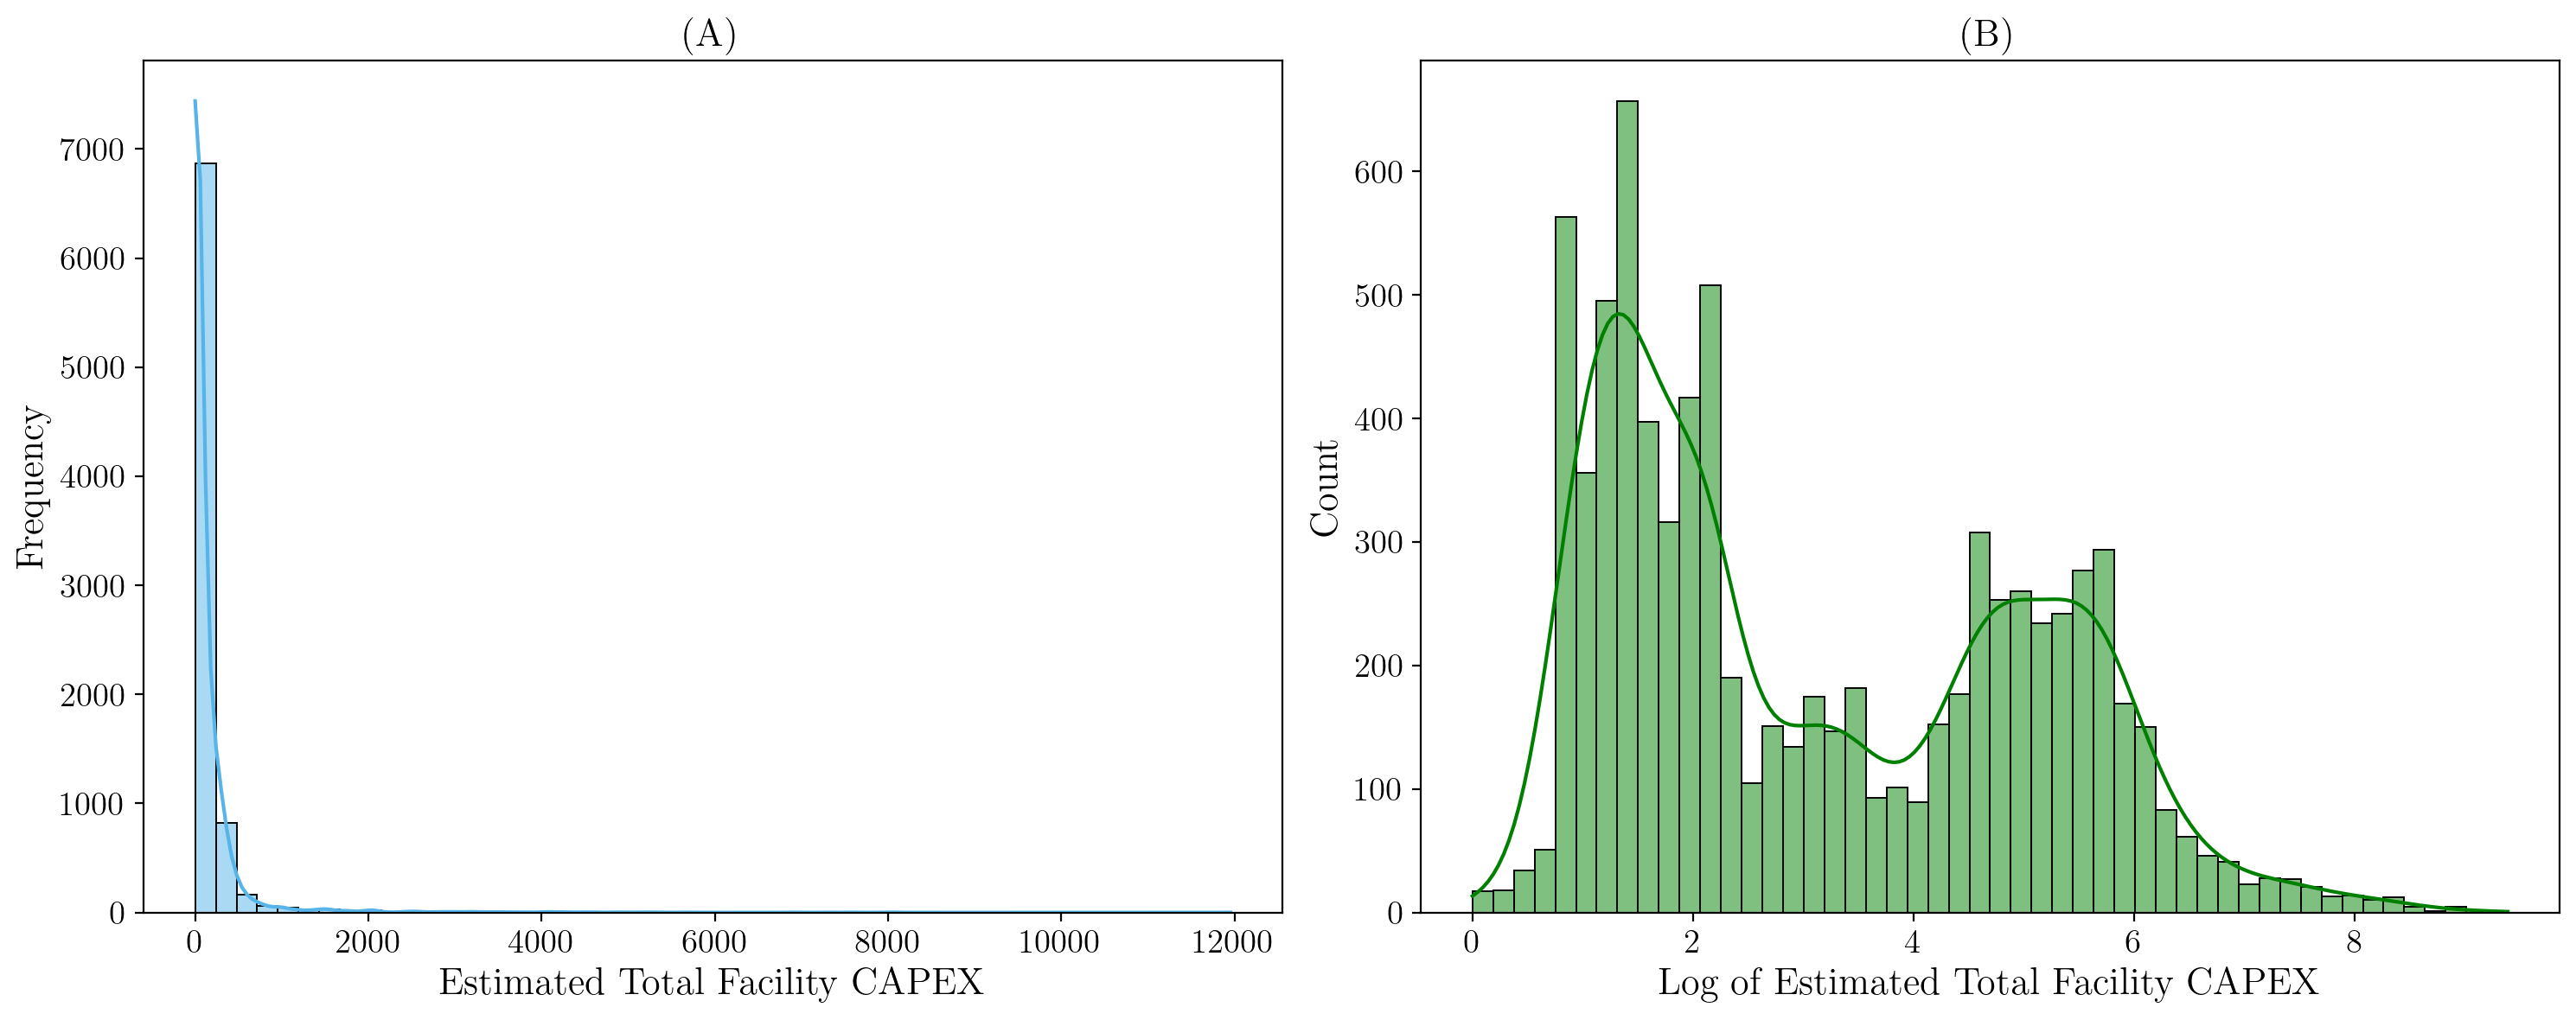

In [33]:
# histogram of CAPEX, Fig A.1
fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=200)
sns.histplot(subset['Estimated_Total_Facility_CAPEX'], bins=50, kde=True, ax=ax[0], color=CB_color_cycle[0])
ax[0].set_xlabel('Estimated Total Facility CAPEX')
ax[0].set_ylabel('Frequency')
ax[0].set_title('(A)')
loging = np.log(subset['Estimated_Total_Facility_CAPEX'] + 1)
sns.histplot(loging, bins=50, kde=True, ax=ax[1], color=CB_color_cycle[1])
ax[1].set_xlabel('Log of Estimated Total Facility CAPEX')
ax[1].set_title('(B)')
plt.tight_layout()
plt.savefig('figures/Methods/histogram_CAPEX.png', dpi=200)
plt.show()

In [10]:
capex = (pd.to_numeric(subset['Estimated_Total_Facility_CAPEX'], errors='coerce').dropna())
skew_val = stats.skew(capex)
kurt_val = stats.kurtosis(capex)
print(f"Skew: {skew_val:.3f}, Kurtosis (excess): {kurt_val:.3f}")

Skew: 10.433, Kurtosis (excess): 166.828


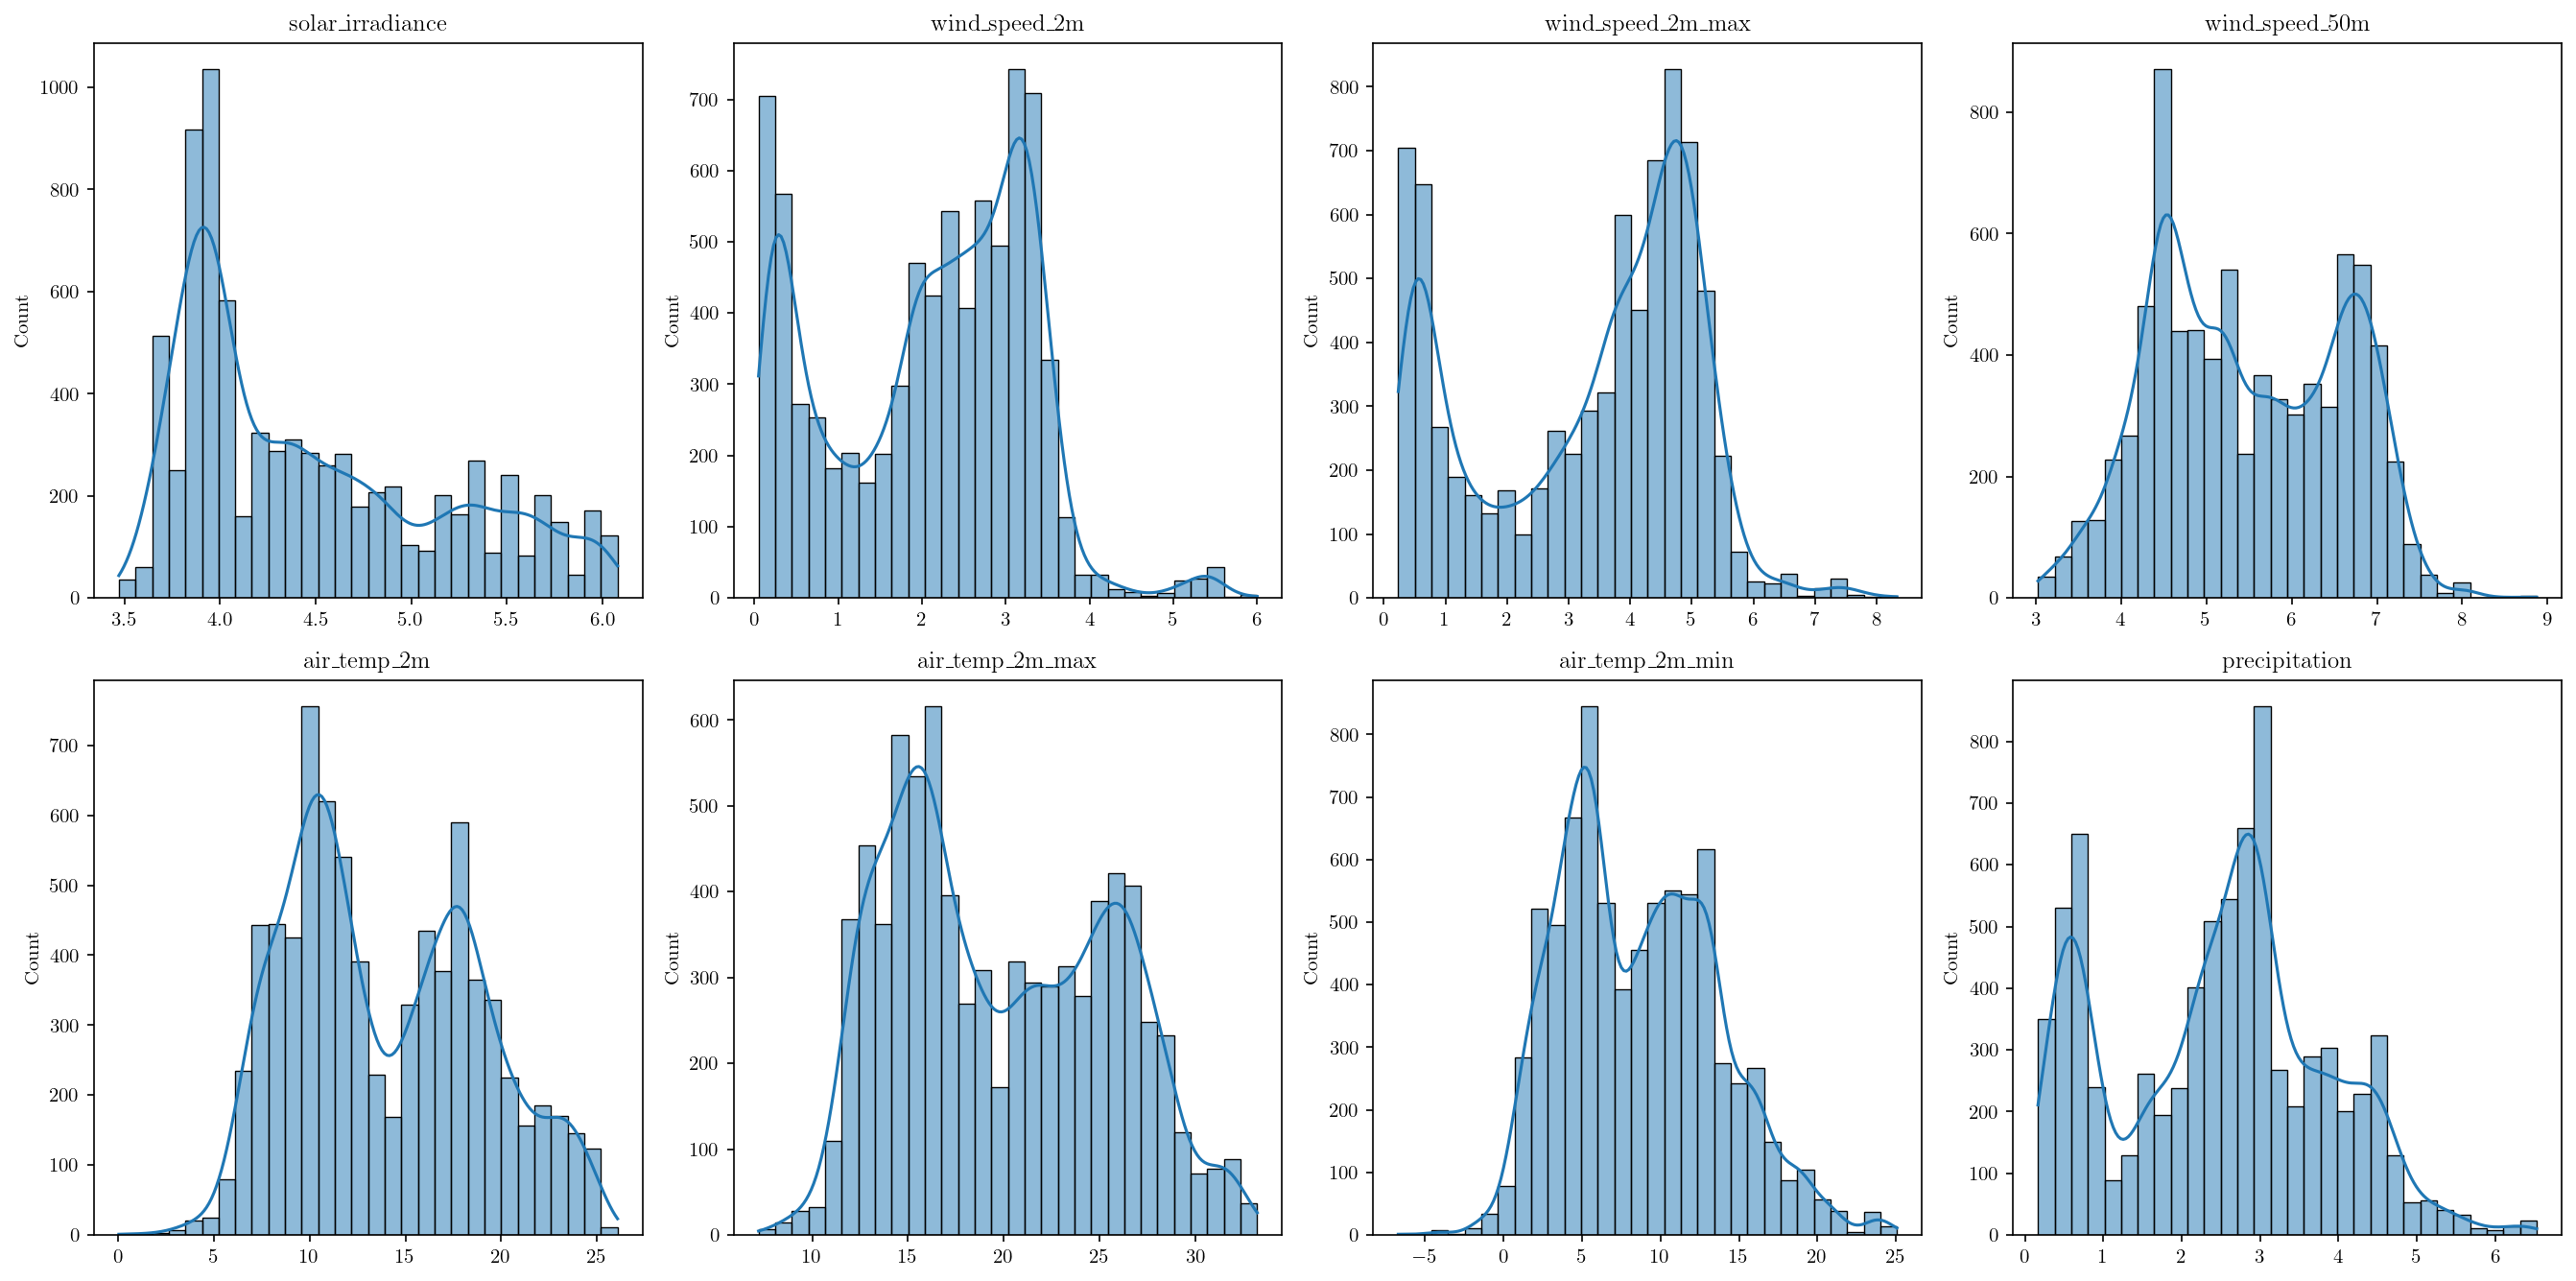

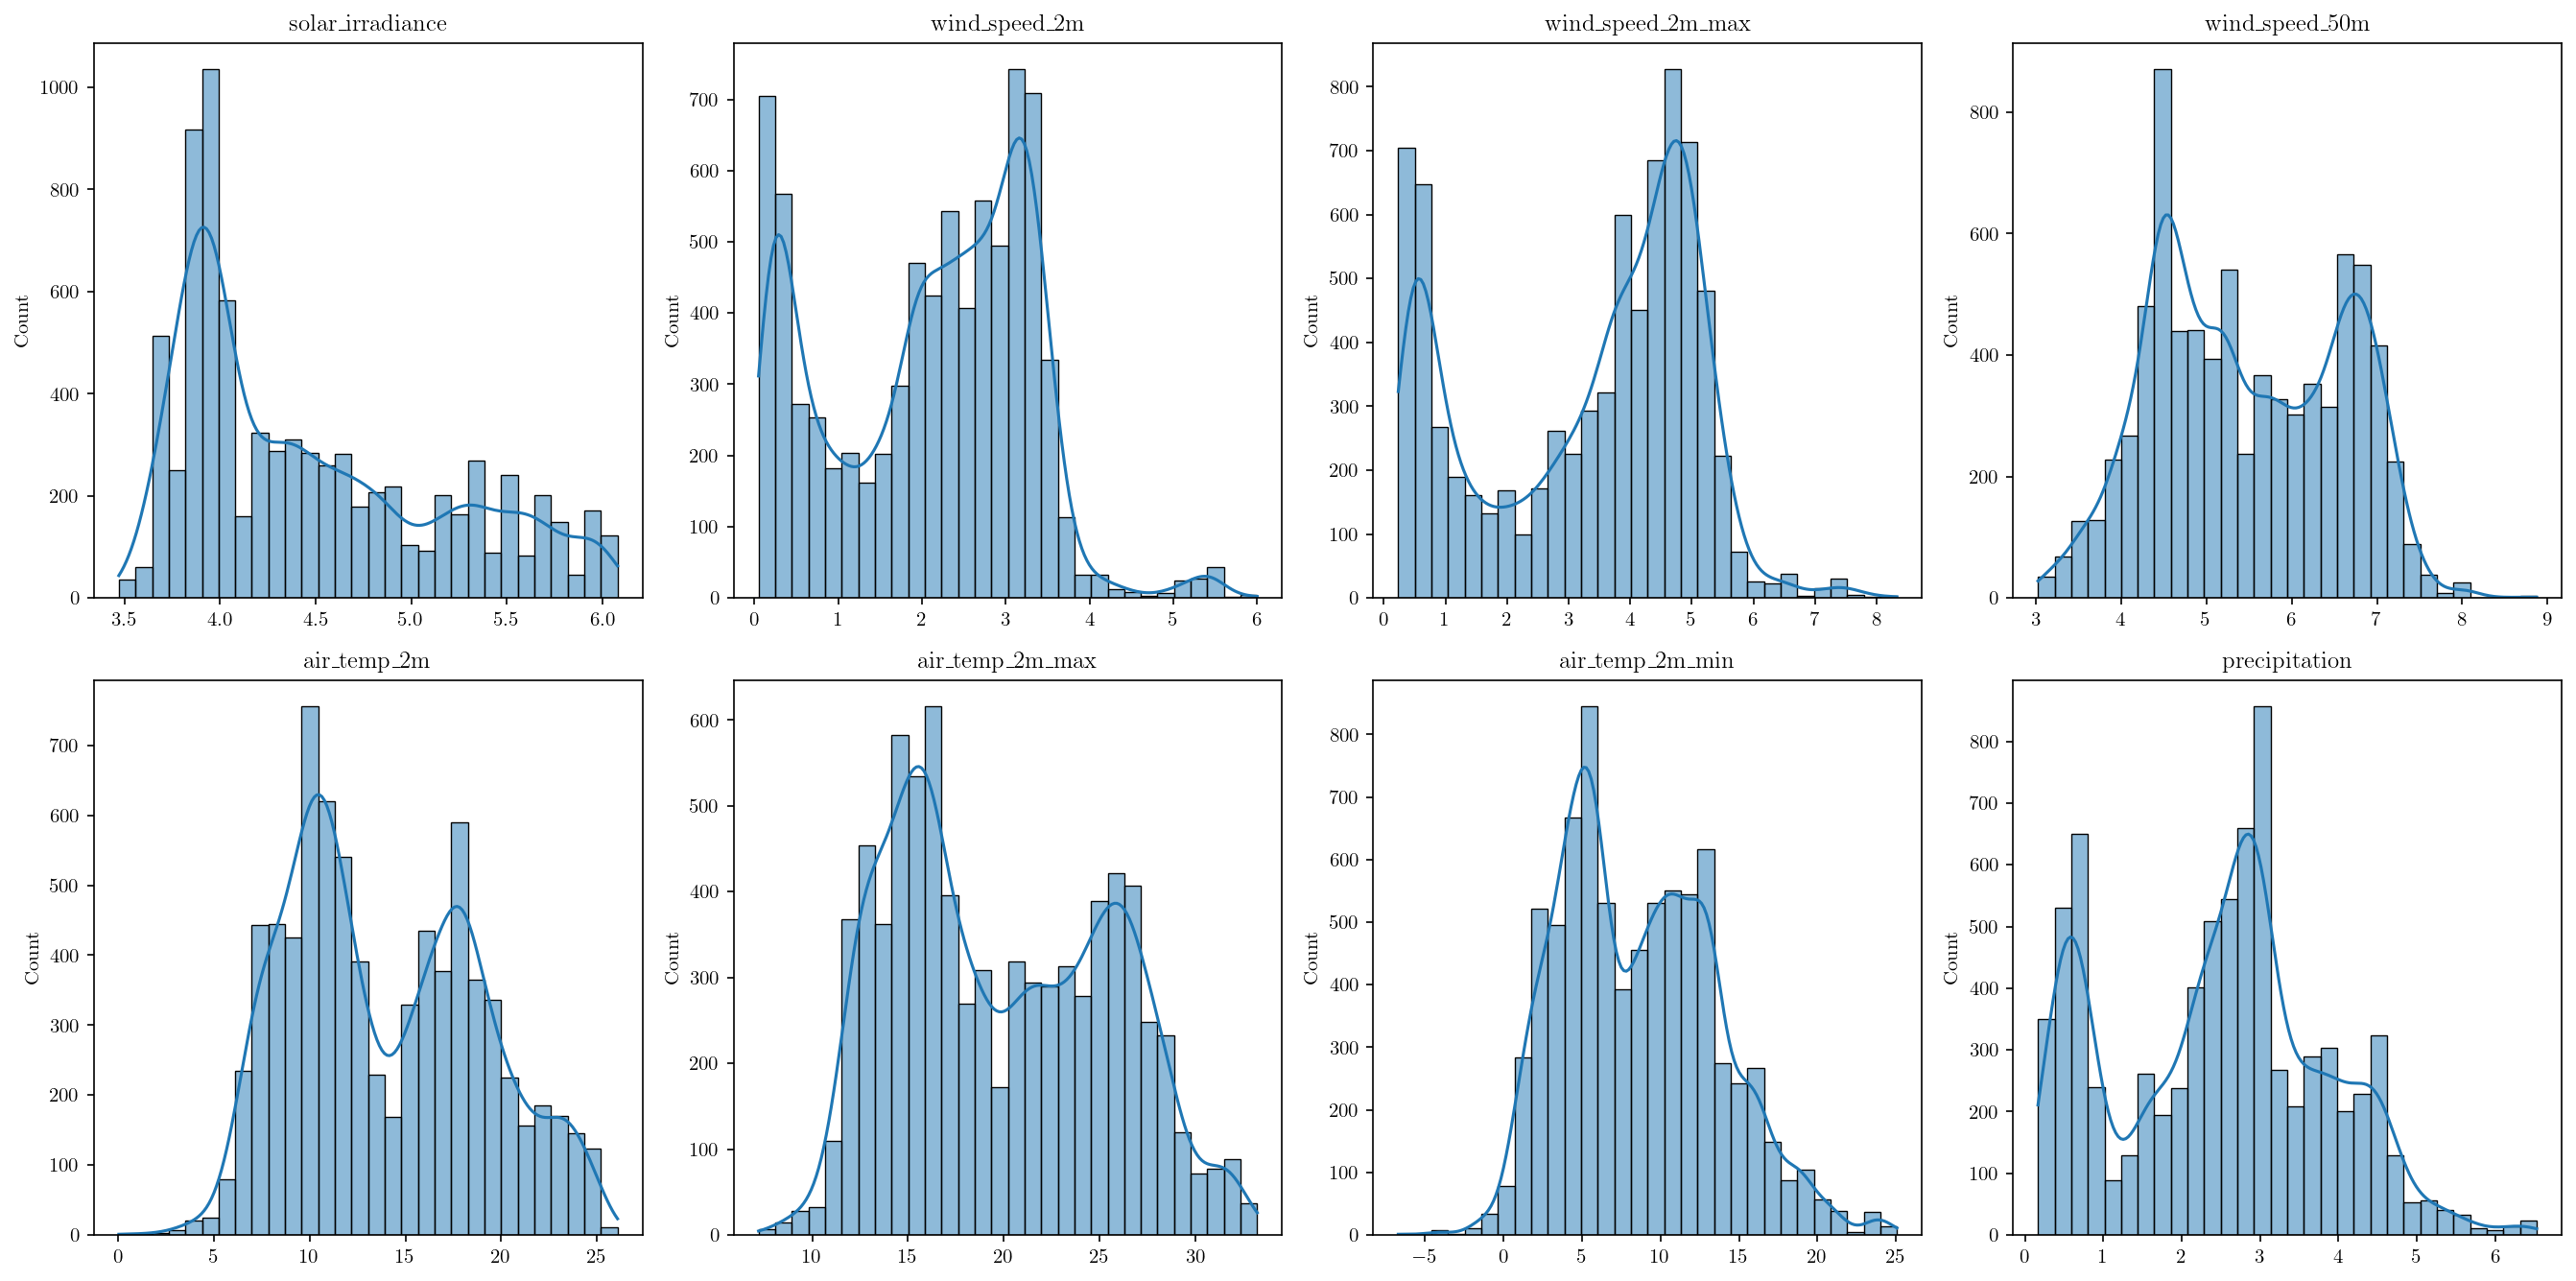

In [ ]:
# plot select weather variables as histograms (6 in total), Fig. A.2
def plot_histograms(df, columns, ncols=3):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 9), dpi=150)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('figures/Methods/weather_data_distribution.png', bbox_inches='tight')
    plt.show()
plot_histograms(subset, SELECT, ncols=4)



#### Getting additional socioeconomic data

In [14]:
years = subset['Announcement_Year'].unique()
years.sort() # for socioeconomic data

In [ ]:
vars_acs = {
    'B19013_001E': 'med_household_income',
    'B23025_005E': 'unemployed',
    'B01003_001E': 'total_pop',
    'B19083_001E': 'gini',
    
}
years = years[:-1] # 2024 not yet available, will be extrapolated, see below
def download_year(year):
    df = censusdata.download(
        src='acs5',
        year=year,
        geo=censusdata.censusgeo([('congressional district', '*')]),
        var=list(vars_acs.keys())
    )
    df = (
        df
        .rename(columns=vars_acs)
        .reset_index()
        .rename(columns={'index': 'geography'})
    )
    df['year'] = year
    return df

max_workers = min(len(years), os.cpu_count() or 1)
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    results = list(
        tqdm(
            executor.map(download_year, years),
            total=len(years),
            desc='Downloading ACS by year'
        )
    )
df_acs = pd.concat(results, ignore_index=True)
df_acs.to_csv('data/posteda/acs_data.csv', index=False)

In [18]:
df_acs['geography_str'] = df_acs['geography'].astype(str)
df_acs = df_acs[df_acs['geography_str'].str.contains('Congressional District')]
df_acs = df_acs[~df_acs['geography_str'].str.contains('not defined')]
df_acs = df_acs[~df_acs['geography_str'].str.contains('at large')]
df_acs = df_acs[~df_acs['geography_str'].str.contains('at Large')]
df_acs.to_csv('data/posteda/acs_data.csv', index=False)

In [ ]:
df_acs['geography'] = df_acs['geography'].astype(str)

state2abbr = dict(pd.read_csv(
    "https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv"
).values)

def extract_cd(geo_str):
    m_state = re.search(r'\),\s*([^:]+):', geo_str)
    state_name = m_state.group(1).strip() if m_state else None
    abbr = state2abbr.get(state_name, '??')
    m_cd = re.search(r'congressional district[:\s]*(\d+)', geo_str, re.IGNORECASE)
    cd = m_cd.group(1).zfill(2) if m_cd else '00'
    return f"{abbr}-{cd}"

df_acs['state_cd'] = df_acs['geography'].apply(extract_cd)

In [20]:
def forecast_by_state(df,
                      vars_to_forecast=None,
                      group_col='state_cd',
                      start_year=2020,
                      end_year=2023,
                      forecast_year=2024):
    if vars_to_forecast is None:
        vars_to_forecast = ['med_household_income', 'unemployed', 'total_pop', 'gini']

    predictions = []
    df = df.copy()
    df['year'] = df['year'].astype(int)

    for state, grp in df.groupby(group_col):
        sub = grp[(grp['year'] >= start_year) & (grp['year'] <= end_year)]
        if len(sub) < 2:
            print(f"Skipping {state!r}: only {len(sub)} years of data")
            continue

        years = sub['year'].values
        pred_row = {group_col: state, 'year': forecast_year}
        for var in vars_to_forecast:
            y = sub[var].values
            m, b = np.polyfit(years, y, 1) # fit simple linear trend
            pred_row[var] = m * forecast_year + b
        predictions.append(pred_row)

    pred_df = pd.DataFrame(predictions)
    df_extended = pd.concat([df, pred_df], ignore_index=True)
    return df_extended

df_extended = forecast_by_state(df_acs)
df_extended.to_csv('data/posteda/acs_with_2024.csv', index=False)
df_acs = df_extended

In [21]:
df_acs = pd.read_csv('data/posteda/acs_with_2024.csv', header=0)
# make mask with no nan values for CD119_2024_Name
mask = subset['CD119_2024_Name'].isna()
subset = subset[~mask]
subset.reset_index(drop=True, inplace=True)

In [ ]:
# for each row in subset, get the CD119_2024_Name, and add the corresponding socioeconomic data from df_acs
no_data_rows = []
vars_to_forecast = ['med_household_income', 'unemployed', 'total_pop', 'gini']
for variable in vars_to_forecast:
    temp_list = []
    for i, row in subset.iterrows():
        cd_name = row['CD119_2024_Name']
        project_year = row['Announcement_Year']

        if pd.isna(cd_name):
            print(f"Row {i} has no CD119_2024_Name")
            continue
        variable_value = df_acs.loc[
            (df_acs['state_cd'] == cd_name) & (df_acs['year'] == project_year), variable]
        if variable_value.empty:
            print(f"Row {i} has no socioeconomic data for {variable}")
            variable_value = pd.Series([np.nan])
            no_data_rows.append(i)
        else:
            variable_value = variable_value.iloc[0]
        temp_list.append(variable_value)
    print(f"Done: {variable}")
    subset[variable] = temp_list

# drop duplicates in no_data_rows and remove
no_data_rows = list(set(no_data_rows))
if no_data_rows:
    print(f"Removing {len(no_data_rows)} rows with no socioeconomic data")
    subset = subset.drop(index=no_data_rows)
    subset.reset_index(drop=True, inplace=True)

missing_rows = subset[subset[vars_to_forecast].isna().any(axis=1)]
if not missing_rows.empty:
    print(f"Missing socioeconomic data for {len(missing_rows)} rows. Removing them.")
    # create mask with no nan values for socioeconomic data
    mask = subset[vars_to_forecast].isna().any(axis=1)
    subset = subset[~mask]
    subset.reset_index(drop=True, inplace=True)


Row 123 has no socioeconomic data for med_household_income
Row 177 has no socioeconomic data for med_household_income
Row 376 has no socioeconomic data for med_household_income
Row 423 has no socioeconomic data for med_household_income
Row 429 has no socioeconomic data for med_household_income
Row 432 has no socioeconomic data for med_household_income
Row 434 has no socioeconomic data for med_household_income
Row 445 has no socioeconomic data for med_household_income
Row 463 has no socioeconomic data for med_household_income
Row 464 has no socioeconomic data for med_household_income
Row 486 has no socioeconomic data for med_household_income
Row 490 has no socioeconomic data for med_household_income
Row 543 has no socioeconomic data for med_household_income
Row 546 has no socioeconomic data for med_household_income
Row 552 has no socioeconomic data for med_household_income
Row 557 has no socioeconomic data for med_household_income
Row 563 has no socioeconomic data for med_household_inco

In [ ]:
# save for analysis
subset.to_csv('data/posteda/subset_final.csv', index=False)